In [2]:
# importing requried library

import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None

%matplotlib inline


In [3]:
raw_data = pd.read_csv("bike_sharing.csv")
raw_data.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


<Axes: >

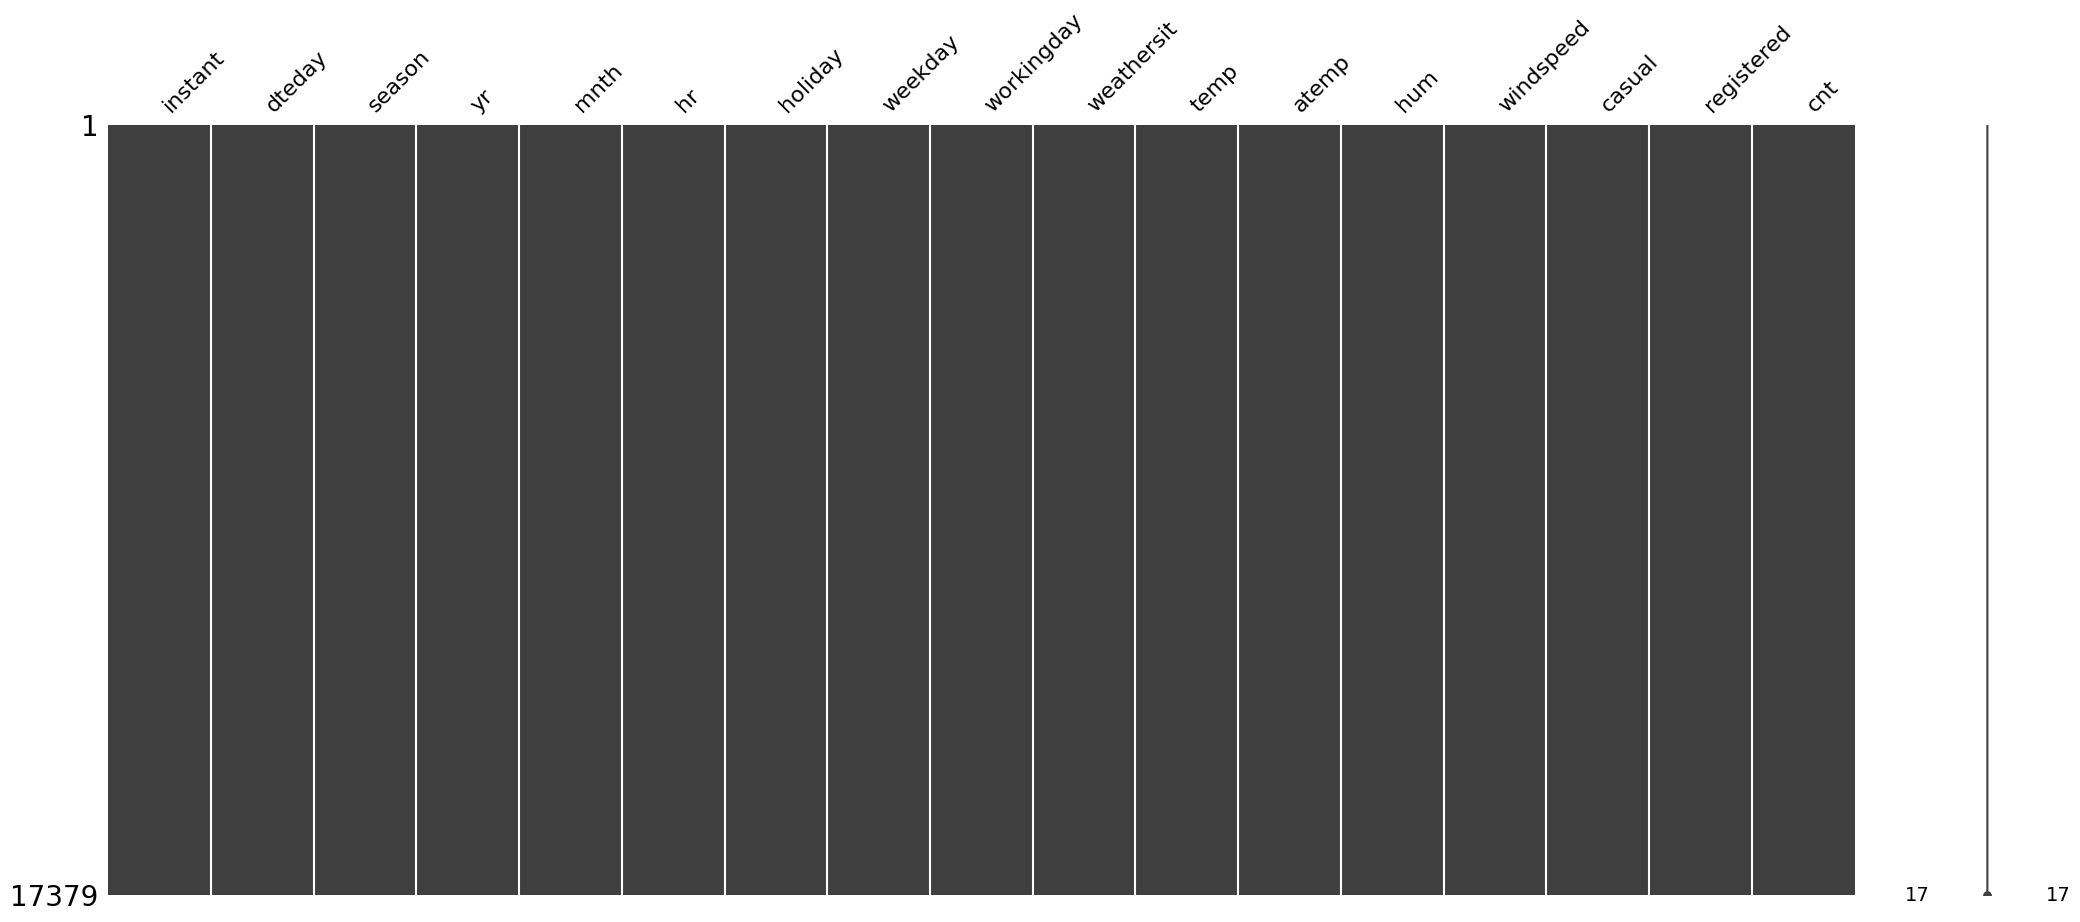

In [4]:
#Checking of Null Values 
msno.matrix(raw_data)

#No missing values in the dataset

In [5]:
raw_data.shape

#We have 17379 observations and 17 variables, our target variable is cnt, which is evaluated by summing casual and registered users

(17379, 17)

In [6]:
raw_data.cnt.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

In [7]:
raw_data.dtypes

#Identify what variables should be categorical...
#season, yr, mnth, holiday, weekday, workingday, weathersit predictors should be categorical type, but they are integer

#Convert Integer to Categorical types
raw_data['season'] = raw_data['season'].astype('category')
raw_data['yr'] = raw_data['yr'].astype('category')
raw_data['mnth'] = raw_data['mnth'].astype('category')
raw_data['holiday'] = raw_data['holiday'].astype('category')
raw_data['weekday'] = raw_data['weekday'].astype('category')
raw_data['workingday'] = raw_data['workingday'].astype('category')
raw_data['weathersit'] = raw_data['weathersit'].astype('category')

#Converting dteday to a proper datetime object in pandas
raw_data['dteday'] = pd.to_datetime(raw_data['dteday'])

#I also want to drop variables which are not required. Eg, instant
raw_data = raw_data.drop(["instant"], axis =1)

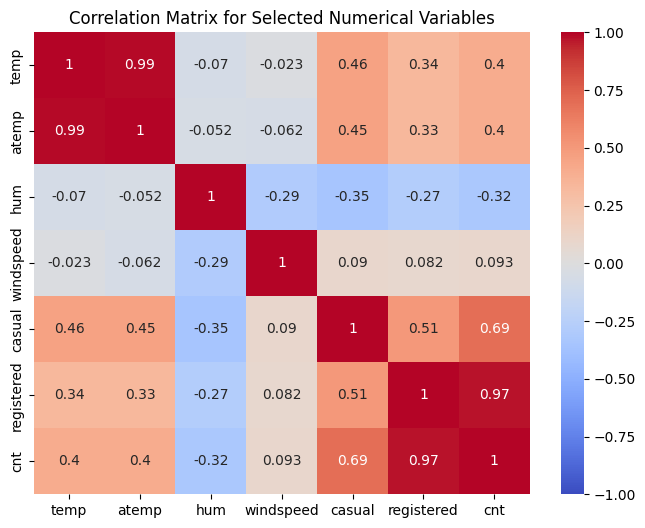

In [8]:
#Correlation Matrix for numerical data
selected_columns = ['temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

# Compute the correlation matrix for the selected columns
corr_matrix = raw_data[selected_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(8, 6))
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Selected Numerical Variables')
plt.show()

#Finding of Correlation analysis
#1) temp and atemp are highly correlated, have to drop 1 of them later due to high multicollinearity
#2) temp and atemp have positive and somewhat strong coorelation with cnt
#3) hum have negative correlation with cnt and windspeed have weak correlation with cnt

In [9]:
#I choose to convert hr into 4 clusters instead, to reduce cardinality and to focus on general trends based on the period of the day instead

def map_hour_to_interval(hr):
    if hr in range(0, 6):
        return 'Night'
    elif hr in range(6, 12):
        return 'Morning'
    elif hr in range(12, 18):
        return 'Afternoon'
    else:
        return 'Evening'

raw_data['time_interval'] = raw_data['hr'].apply(map_hour_to_interval)
raw_data['time_interval'] = raw_data['time_interval'].astype('category')

#I convert weekday of 0 to 6 to either weekend or weekday
def map_dayofweek_to_weekdayorweekend(weekday):
    if weekday == 6 or weekday == 0:
        return 'Weekend'
    else:
        return 'Weekday'
    
raw_data['weekend'] = raw_data['weekday'].apply(map_dayofweek_to_weekdayorweekend)
raw_data['weekend'] = raw_data['weekend'].astype('category')




In [10]:
#For Month variable (1-12), i choose to remove it as I plan to group it by seasons instead
#Remove hr as already clustered into 4 categories previously
#Remove dteday as there are too many unique objects, its already described by other variables
#Remove weekday as already clustered into weekday/weekend previously
#Remove atemp due to high collinearity with temp

raw_data = raw_data.drop(["mnth","hr","dteday","weekday","atemp"], axis =1)

In [11]:
raw_data.head()


,season,yr,holiday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,time_interval,weekend
0,1,0,0,0,1,0.24,0.81,0.0,3,13,16,Night,Weekend
1,1,0,0,0,1,0.22,0.80,0.0,8,32,40,Night,Weekend
2,1,0,0,0,1,0.22,0.80,0.0,5,27,32,Night,Weekend
3,1,0,0,0,1,0.24,0.75,0.0,3,10,13,Night,Weekend
4,1,0,0,0,1,0.24,0.75,0.0,0,1,1,Night,Weekend


In [12]:
#Outlier Management
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to remove outliers from all numerical columns
numerical_columns = ['temp', 'hum', 'windspeed', 'casual', 'registered', 'cnt']

outlier_raw_data = raw_data.copy()

for column in numerical_columns:
    outlier_raw_data = remove_outliers(outlier_raw_data, column)

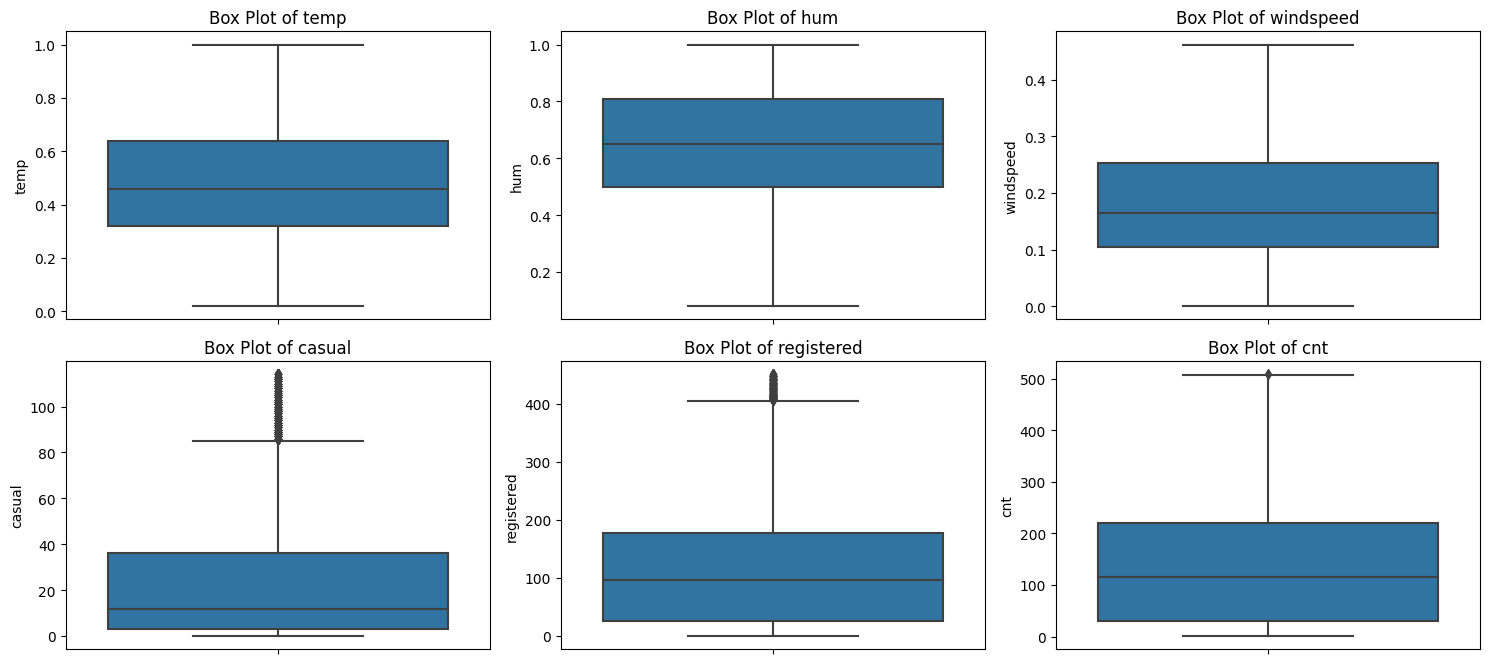

In [14]:
# Step 1: Create box plots for each numerical variable
plt.figure(figsize=(15, 10))
for i, column in enumerate(numerical_columns):
    plt.subplot(3, 3, i + 1)  
    sn.boxplot(data=outlier_raw_data, y=column)
    plt.title(f'Box Plot of {column}')

plt.tight_layout()
plt.show()



[Text(0.5, 0, 'workingday'),
 Text(0, 0.5, 'cnt'),
 Text(0.5, 1.0, 'Boxplot for cnt vs workingday')]

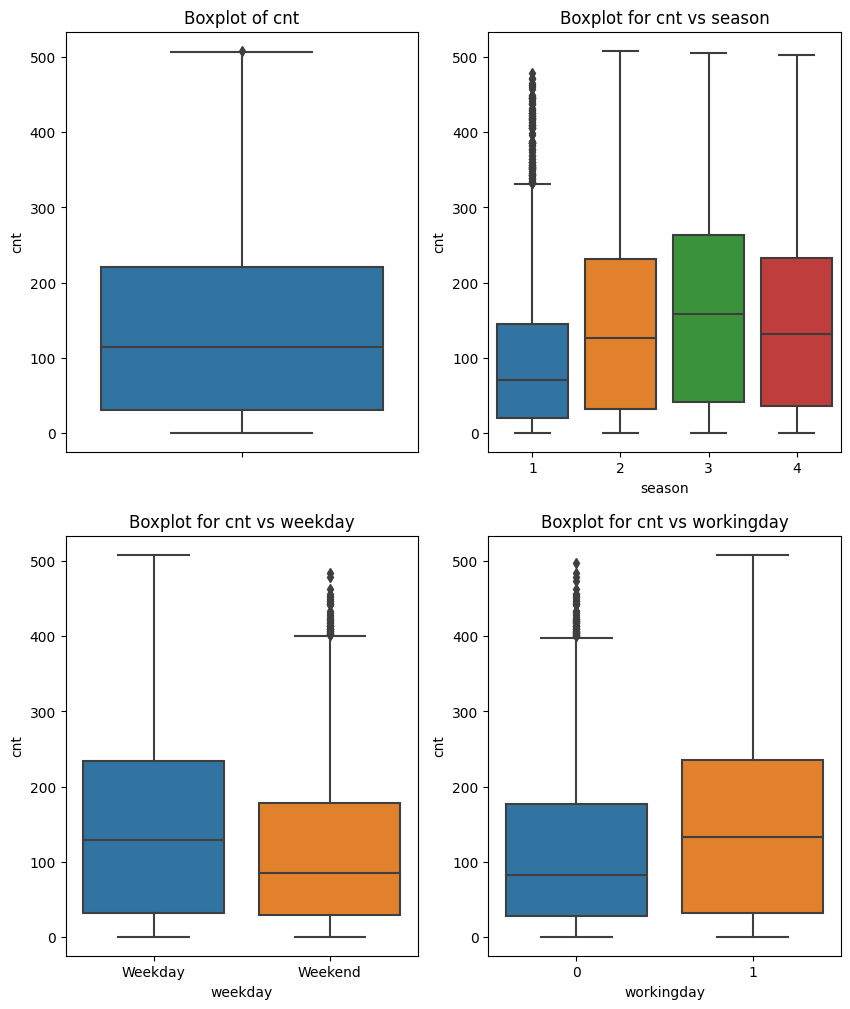

In [15]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(10,12)
sn.boxplot(data=outlier_raw_data,y="cnt",orient='v',ax=axes[0][0])
sn.boxplot(data=outlier_raw_data,y="cnt",x="season",orient='v',ax=axes[0][1])
sn.boxplot(data=outlier_raw_data,y="cnt",x="weekend",orient="v",ax=axes[1][0])
sn.boxplot(data=outlier_raw_data,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='cnt',title = "Boxplot of cnt")
axes[0][1].set(xlabel="season",ylabel="cnt",title="Boxplot for cnt vs season")
axes[1][0].set(xlabel="weekday", ylabel="cnt",title="Boxplot for cnt vs weekday")
axes[1][1].set(xlabel="workingday",ylabel="cnt",title="Boxplot for cnt vs workingday")

In [16]:
outlier_raw_data.head()

,season,yr,holiday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,time_interval,weekend
0,1,0,0,0,1,0.24,0.81,0.0,3,13,16,Night,Weekend
1,1,0,0,0,1,0.22,0.80,0.0,8,32,40,Night,Weekend
2,1,0,0,0,1,0.22,0.80,0.0,5,27,32,Night,Weekend
3,1,0,0,0,1,0.24,0.75,0.0,3,10,13,Night,Weekend
4,1,0,0,0,1,0.24,0.75,0.0,0,1,1,Night,Weekend


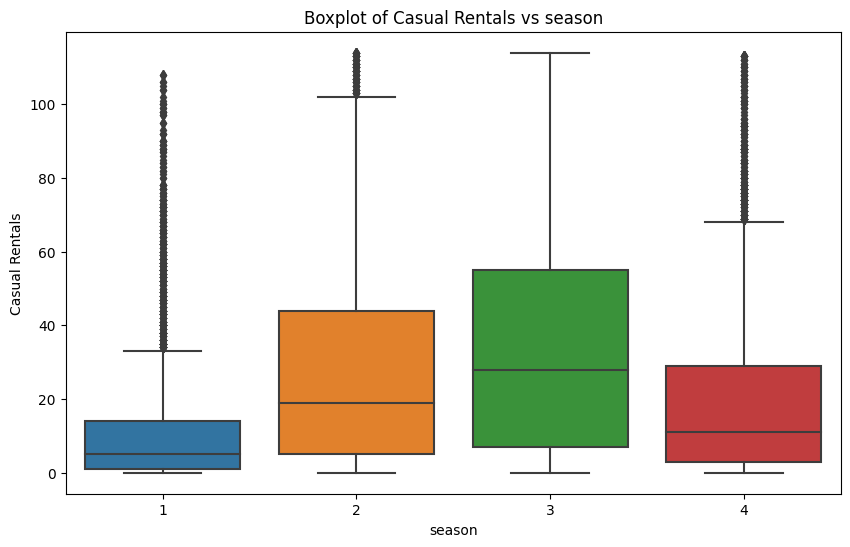

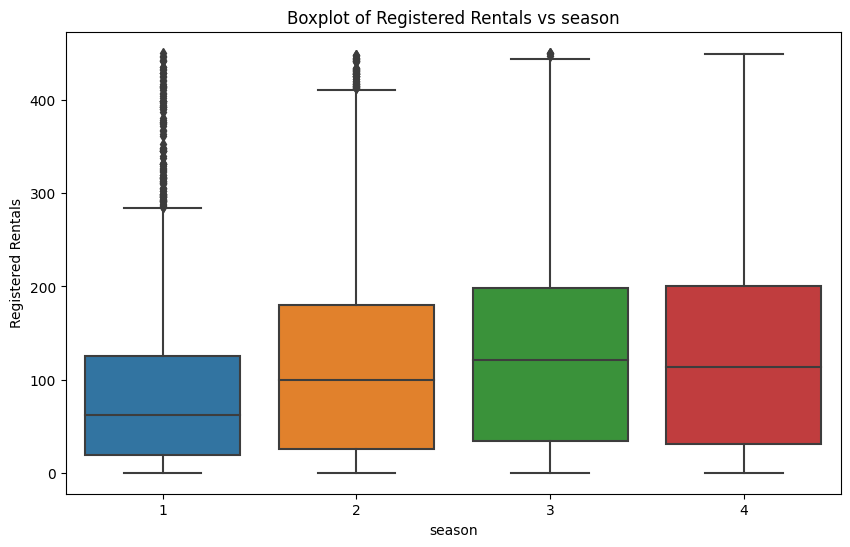

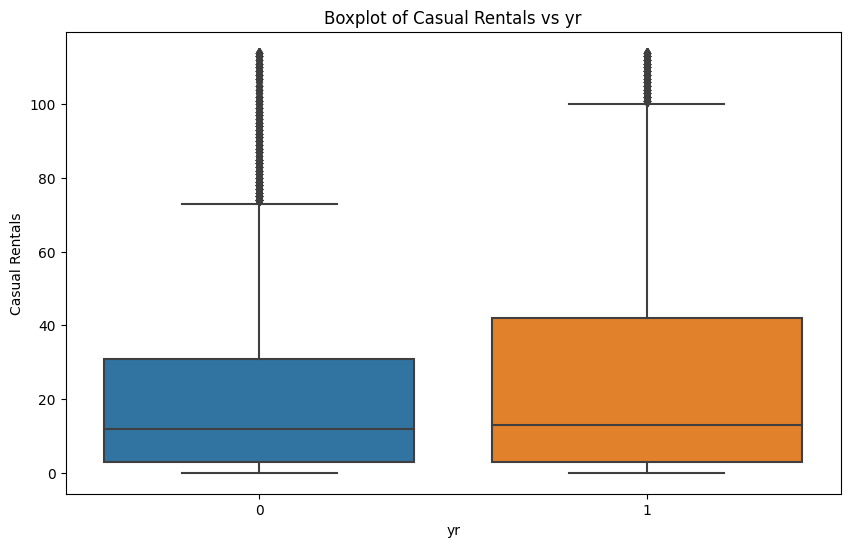

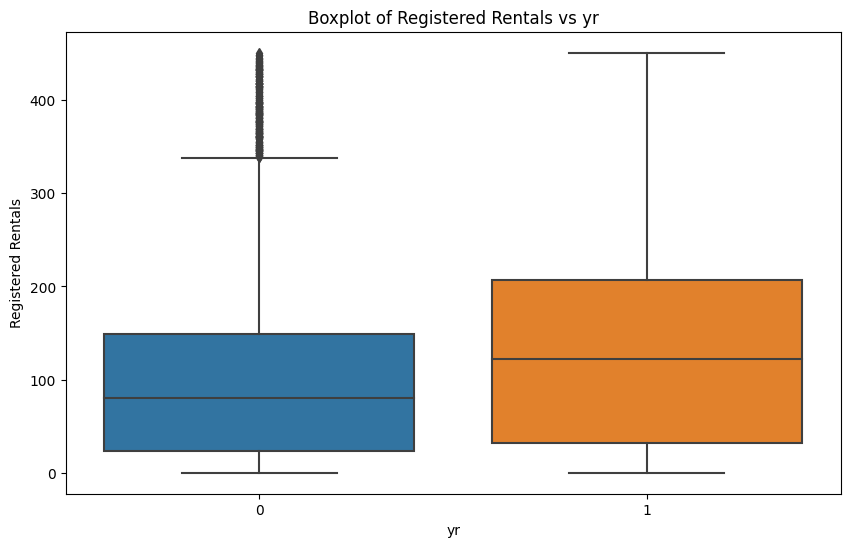

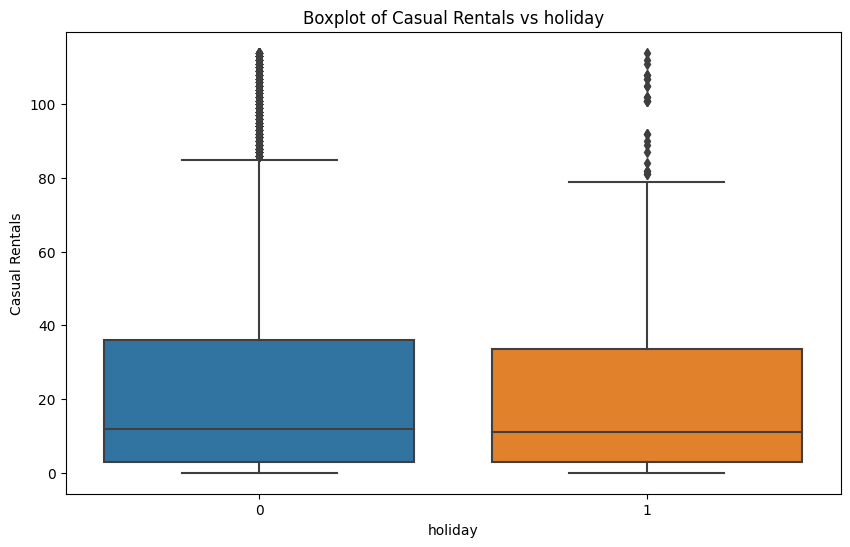

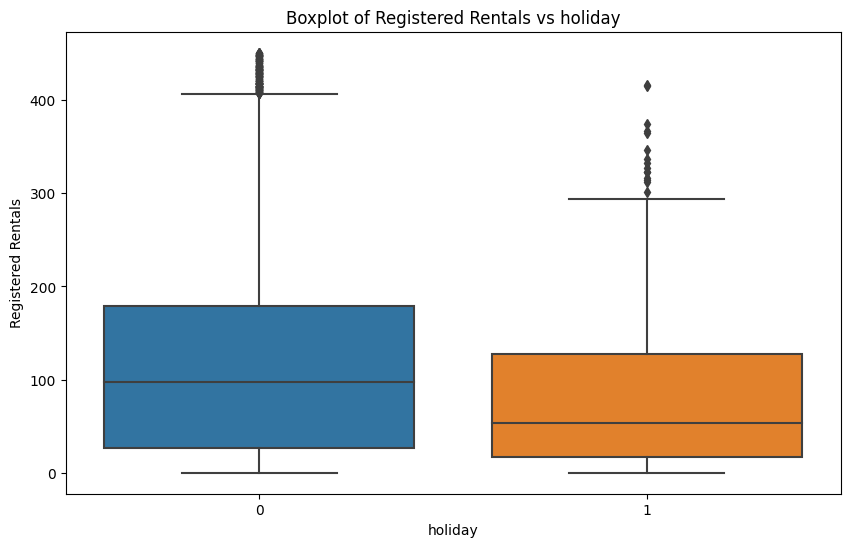

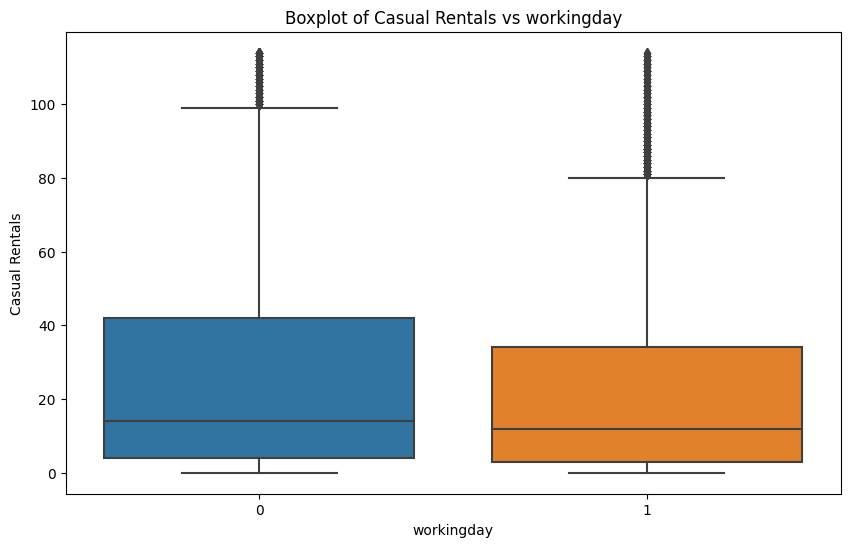

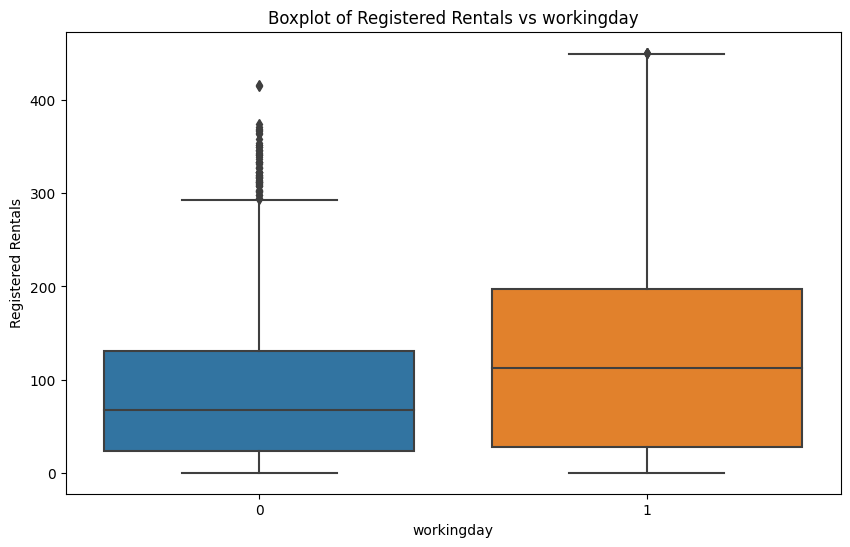

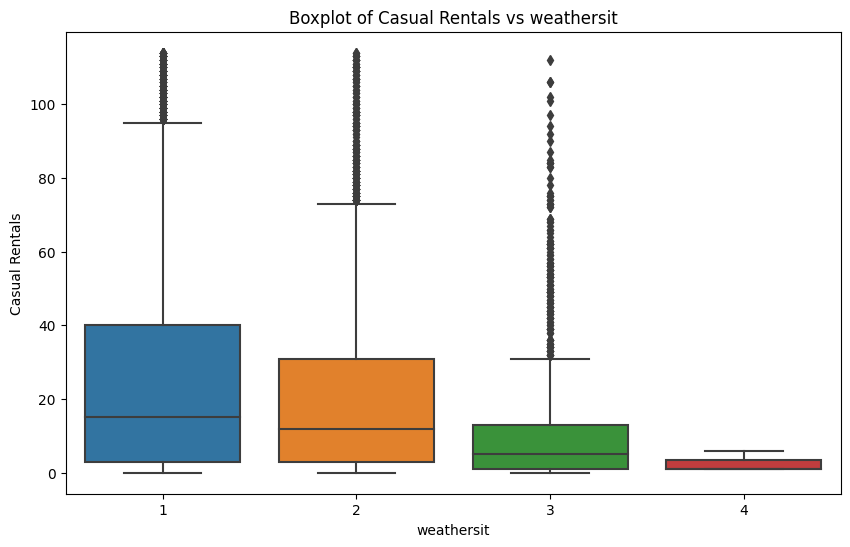

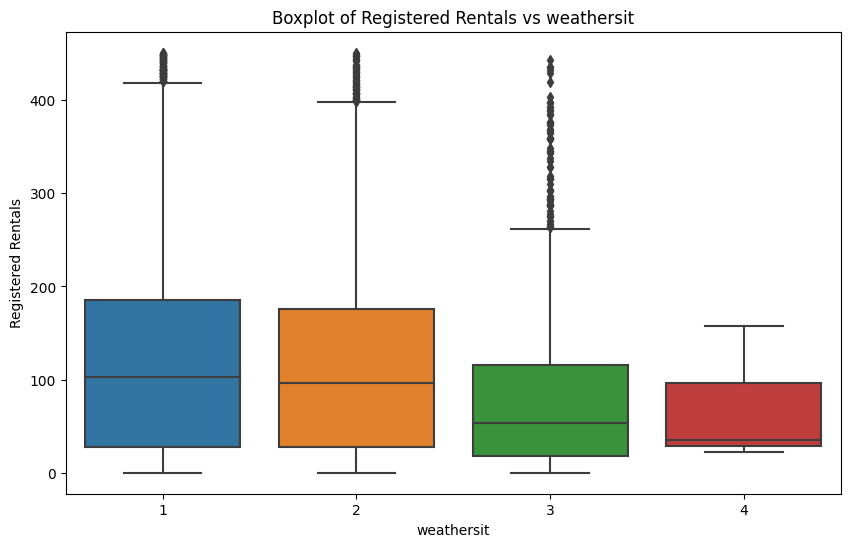

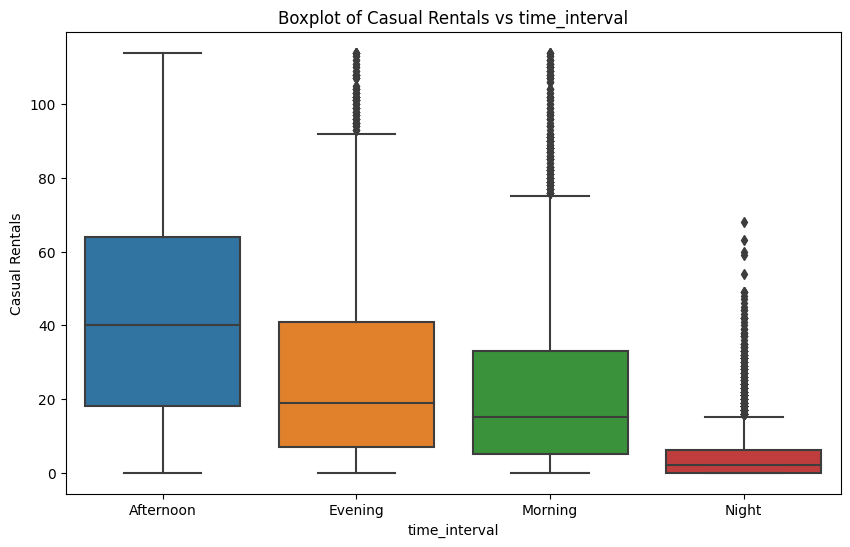

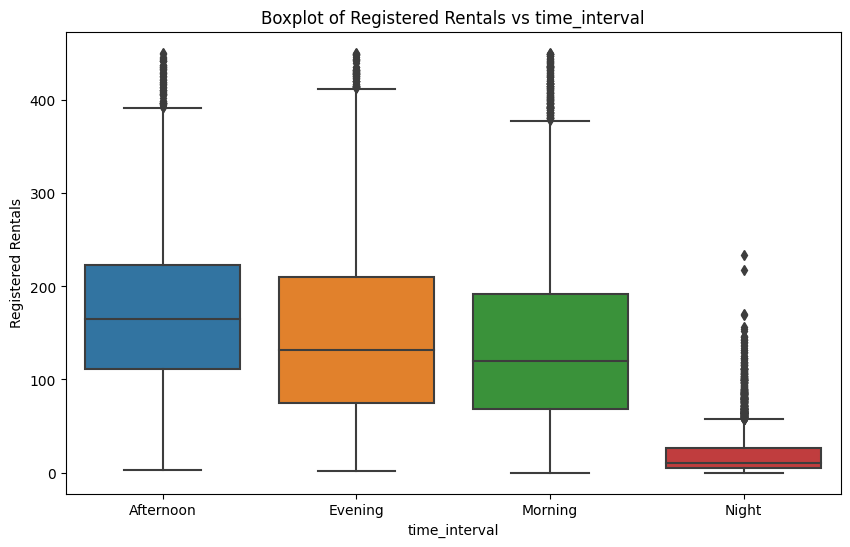

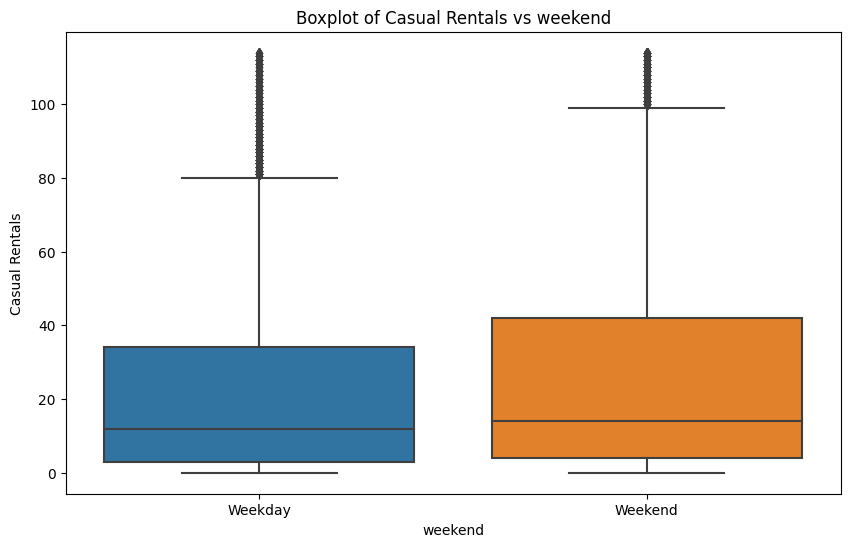

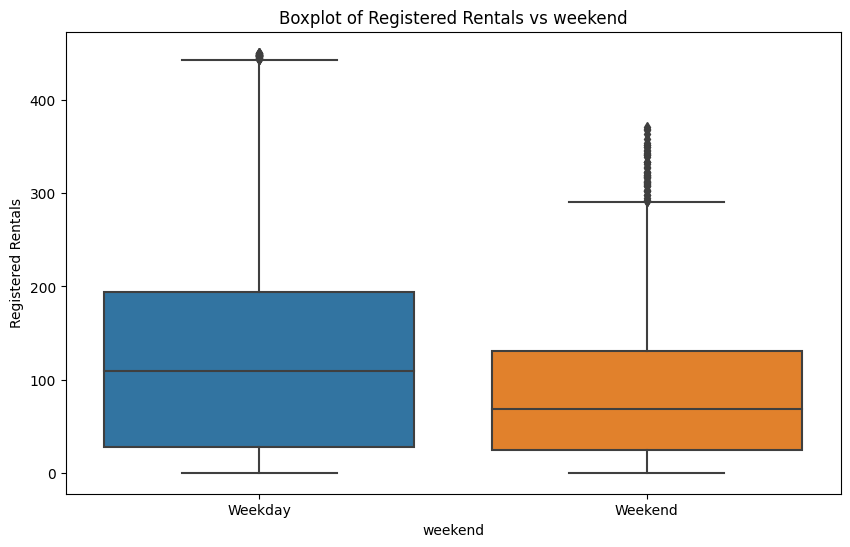

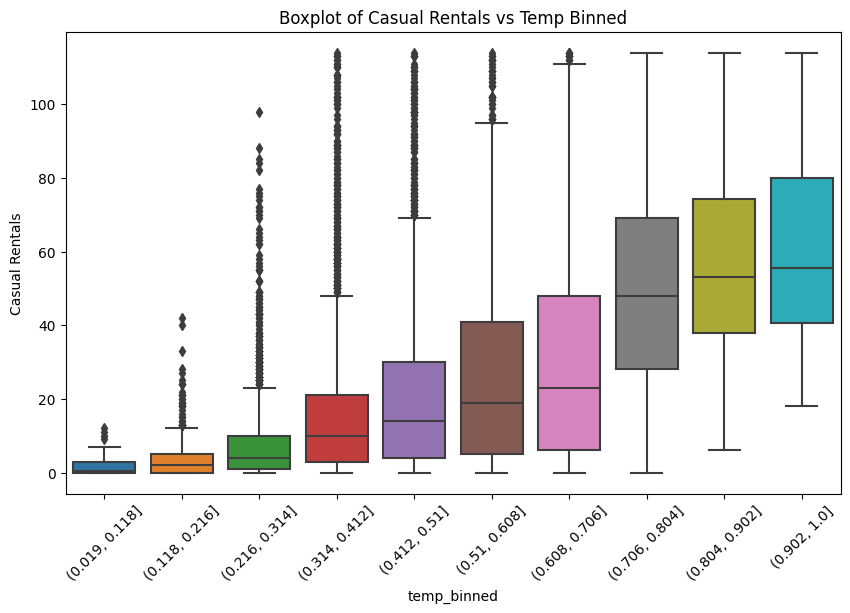

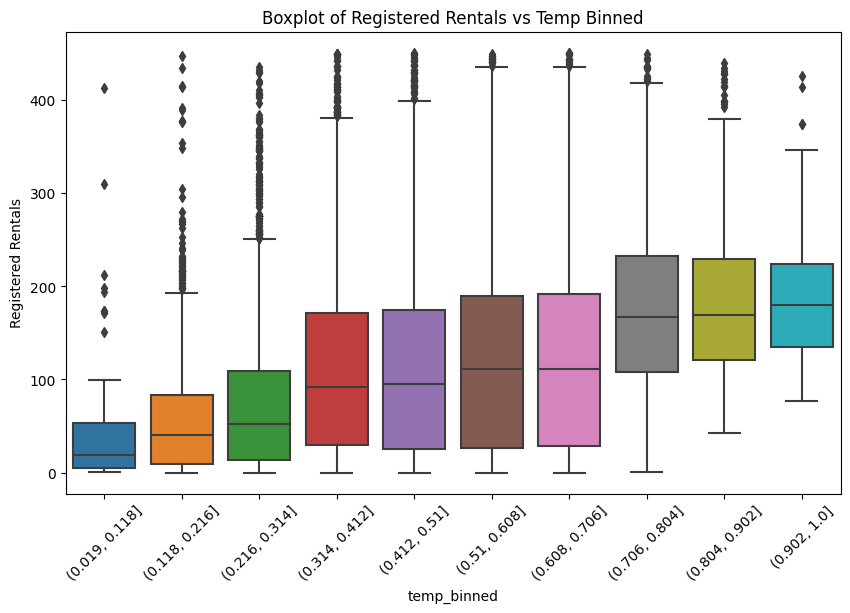

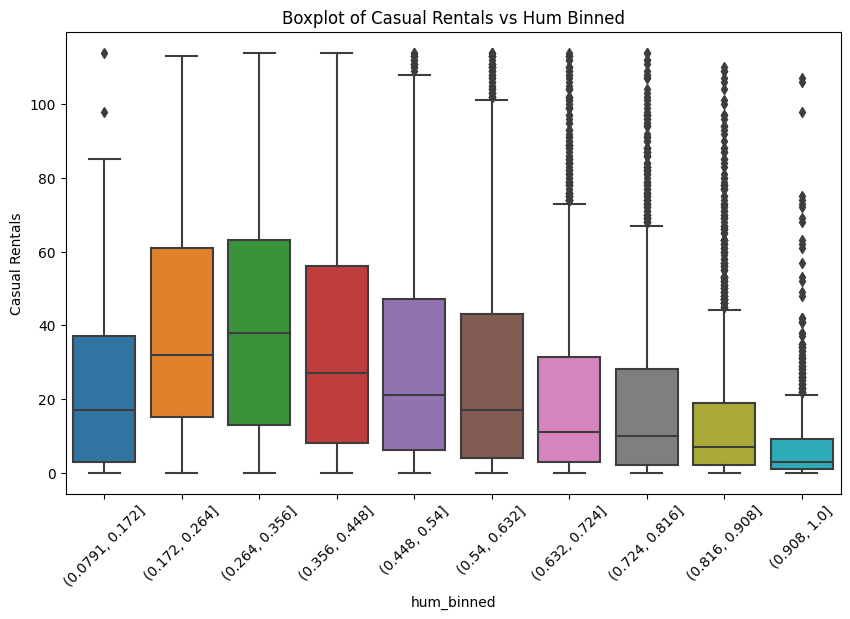

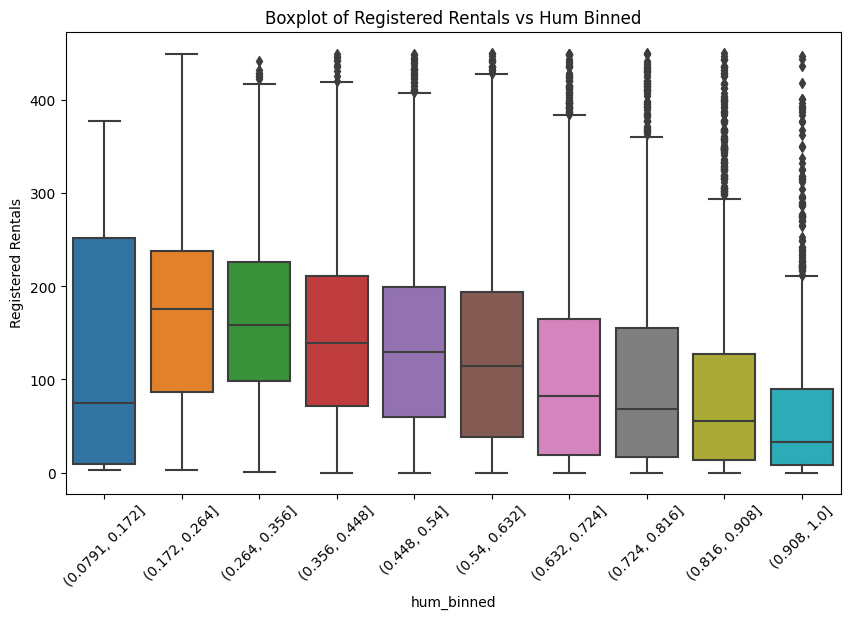

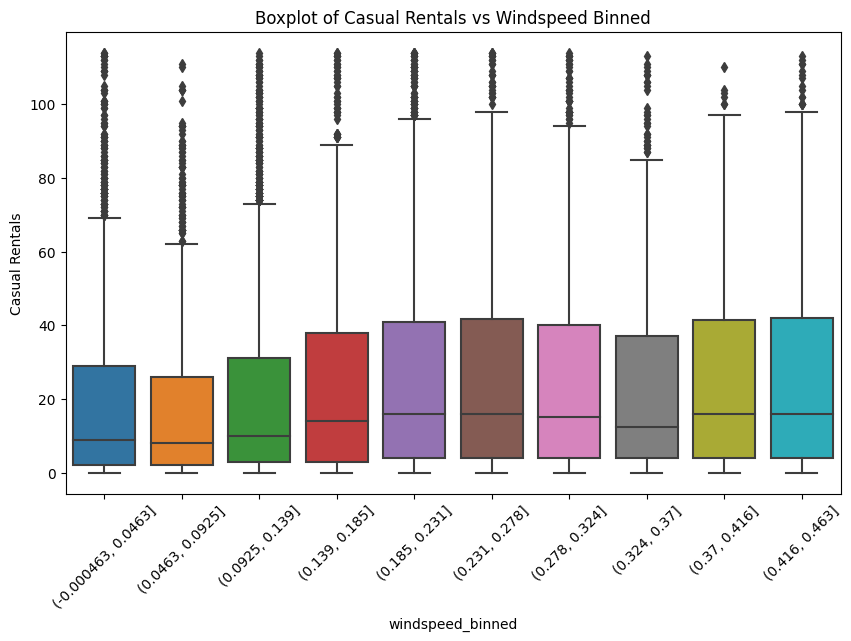

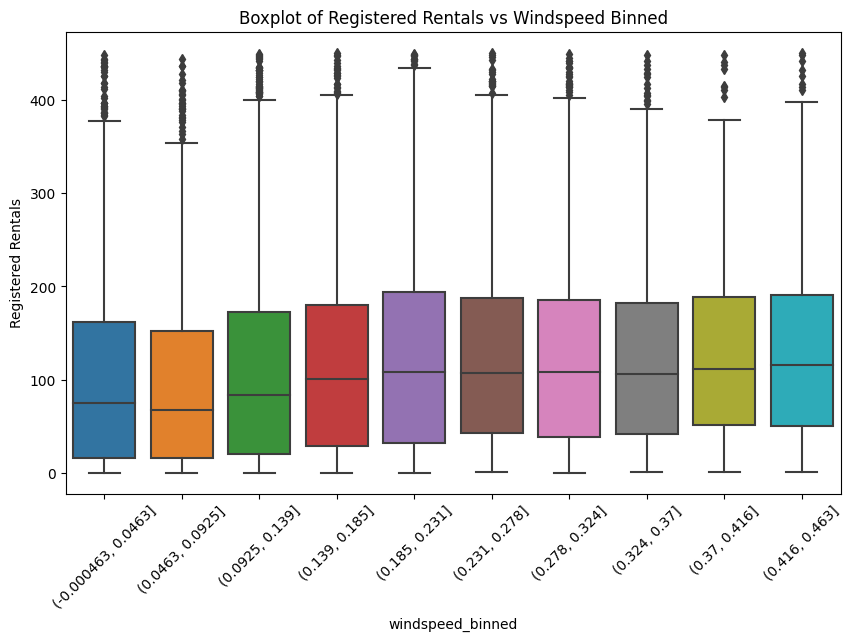

In [17]:
# Prepare the features and columns to plot against
categorical_features = ['season', 'yr', 'holiday', 'workingday', 'weathersit','time_interval','weekend']  # Adjust based on your columns
continuous_features = ['temp', 'hum', 'windspeed']

# 1. Plot boxplots for categorical variables
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    sn.boxplot(x=feature, y='casual', data=outlier_raw_data)
    plt.title(f'Boxplot of Casual Rentals vs {feature}')
    plt.ylabel('Casual Rentals')
    plt.show()

    plt.figure(figsize=(10, 6))
    sn.boxplot(x=feature, y='registered', data=outlier_raw_data)
    plt.title(f'Boxplot of Registered Rentals vs {feature}')
    plt.ylabel('Registered Rentals')
    plt.show()

# 2. Plot boxplots for continuous variables using bins
for feature in continuous_features:
    # Bin the continuous feature into intervals (you can adjust the number of bins)
    outlier_raw_data[f'{feature}_binned'] = pd.cut(outlier_raw_data[feature], bins=10)

    plt.figure(figsize=(10, 6))
    sn.boxplot(x=f'{feature}_binned', y='casual', data=outlier_raw_data)
    plt.title(f'Boxplot of Casual Rentals vs {feature.capitalize()} Binned')
    plt.xticks(rotation=45)
    plt.ylabel('Casual Rentals')
    plt.show()

    plt.figure(figsize=(10, 6))
    sn.boxplot(x=f'{feature}_binned', y='registered', data=outlier_raw_data)
    plt.title(f'Boxplot of Registered Rentals vs {feature.capitalize()} Binned')
    plt.xticks(rotation=45)
    plt.ylabel('Registered Rentals')
    plt.show()

# Drop the binned columns after visualization (optional)
outlier_raw_data.drop([f'{feature}_binned' for feature in continuous_features], axis=1, inplace=True)


In [18]:
#End of EDA
#Some observations made from the boxplots

#1)<Categorical>
#Low rentals for Season 1 (Spring Season)
#Higher total rentals (Registered and Casual)in Year 2012 
#Higher Registered rentals on non-holidays
#Higher registered rentals on working days
#Cnt drops for both casual and registered as weather becomes worse from 1-4
#Cnt is highest in Afternoon (12pm - 6pm)
#Higher Casual rentals on weekend, but higher registered rentals on weekdays

#<Numerical>
#Higher Casual and Registered rentals as temperature increases
#Higher Casual and Registered rentals at lower humidity
#Cnt are quite similar for all the windspeed ranges

##Proceed with Model Fitting and Evaluating